# **Roadmap**

In this project, we ask if the texts of central bank monetary policy announcements can foreshadow the interest rate policy decision in the subsequent policy meeting.  After importing modules and preprocessing the data, we:

* Create dense networks to predict policy interest rates set by the US Federal Reserve and the European Central Bank.  The Keras Tuner helped us refine the model.

* Add text to the model of the US interest rate policy.  The main model combines bidirectional LSTM layers and Dense layers.  

* We test the main model on three different embeddings: trained on the corpus itself, a pre-train set of specialized embeddings for central banks, and GloVe.

* Variations of the model are tested using the corpus-derived embeddings.  These include testing the model on a small sample data from the European Central Bank (ECB).

**This is the first of two notebooks for this project.  The second notebook is used for additional experiments.**

# **Imports**



In [ ]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import os
import json

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MinMaxScaler

pd.options.display.max_colwidth = 999


# **Read and View Data**

The dataset was compiled from the files for the United States Federal Reserve Bank and the (usa_df.csv) and the European Union Euporean Central Bank (ecb_df.csv) the initial corpus at https://github.com/CarolMoore19/Central-Bank-Texts-Parsed, which contains announcements following all scheduled meetings of monetary policy committees. These data were further cleaned and prepared offline, and combined with macroeconomic variables downloaded from the Fed's public site for economic data, https://fred.stlouisfed.org/ and various sites covering the Euro Area.

In [ ]:
df=pd.read_excel('us_ecb_nonumbs_clean_final8.xlsx')

## Key Variables

* *Bank*:  The US Federal Reserve or European Central Bank, which conducts monetary policy for the Euro Area.

* *rate_curr*:  the policy (target) interest rate set at the monetary policy committee meeting.  For the US, this is the median of the upper and lower target range (which differ by .25 points).  The most relevant interest rate, the main refinancing operations rate, was not available for the mid-2000s. Instead we used the median of the rate paid to banks for deposits into the ECB and the rate on marginal lending.  The main refinancing operations always lies between these two rates and follows the same trend.

* *rate_next*:  the rate set at the subsequent meeting.

* *rate_change*:  -1 if the rate fell, 0 if remained the same, and 1 if increased.

Macroeconomic variables are:

* *urate*:  the unemployment rate on the first day of the month of the meeting. Seasonally adjusted.

* *nairu and twice_urate_less_nairu*:  The natural rate of unemployment (nairu) represents unemployment rate consistent with full resource utilization. Twice_urate_less_nairu is a more theoretically correct measure of economic slack (only available for the US). Only available for the US.

* *pce_inf*:  inflation for personal consumption expenditures, less food and energy, on the first day of the month of the meeting.  This is the inflation concept that both the Federal Reserve and the ECB use for policy. Seasonally adjustd.

* *effective_ffr*:  The market federal funds rate on the first day of the month of the meeting.  When setting policy, the fed is trying to influence this interest rate.  For the ECB, analagous short-term bank interest rate is the Euro Short Term Rate (ESTR) and its predecessor the Eonia.

Text variables are:

* statement:  Press announcements following monetary policy committee meetings.  We removed numbers, dates, names and stopwords from the text.  We also removed boilerplate phrases which changed gradually over time and may be spuriously correlated with interest rate trends.  Because the Keras tokenizer does not handle hyphenated words that are common in these documents (e.g., "long-term"), we replaced hyphens with white space.

* text_include:  if 1, can be included in a text analysis.  Otherwise, can only be used for quantitative analysis.  All ECB texts before 2017 are excluded because they consist entirely of boilerplate.

Other variables - filename, date_dt, and chron_order_in_country - exist to to keep track of the meeting dates and do not enter into the analysis below.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   bank                    434 non-null    object 
 1   filename                434 non-null    object 
 2   date_dt                 434 non-null    object 
 3   chron_order_in_country  434 non-null    int64  
 4   rate_curr               434 non-null    float64
 5   rate_next               434 non-null    float64
 6   rate_change             434 non-null    int64  
 7   urate                   434 non-null    float64
 8   inf                     434 non-null    float64
 9   eff_rate                434 non-null    float64
 10  statement               434 non-null    object 
 11  text_include            434 non-null    int64  
 12  nairu                   169 non-null    float64
 13  twice_urate_less_nairu  169 non-null    float64
 14  minutes                 162 non-null    ob

## Structure

Although we can think of the problem as time-series prediction, our data structure also enables us to treat this as a standard supervised learning problem.  The prediction target is _rate_next_.

In [ ]:
df.loc[3:4,['bank','date_dt','rate_curr','rate_next','urate','twice_urate_less_nairu','inf','eff_rate','statement']]

,bank,date_dt,rate_curr,rate_next,urate,twice_urate_less_nairu,inf,eff_rate,statement
3,usfed,9/24/02,1.75,1.25,5.7,1.161582,2.43474,1.85,keep its target for the federal funds rate unchanged at. the information that has become available since the last meeting of the committee suggests that aggregate demand is growing at a moderate pace. over time the current accommodative stance of monetary policy coupled with still robust underlying growth in productivity should be sufficient to foster an improving business climate. however considerable uncertainty persists about the extent and timing of the expected pickup in production and employment owing in part to the emergence of heightened geopolitical risks. consequently the committee believes that for the foreseeable future against the background of its long run goals of price stability and sustainable economic growth and of the information currently available the risks are weighted mainly toward conditions that generate economic weakness.
4,usfed,11/6/02,1.25,1.25,5.9,1.582877,1.69805,1.23,lower its target for the federal funds rate by basis points to. in a related action the board of governors approved a basis point reduction in the discount rate to. the committee continues to believe that an accommodative stance of monetary policy coupled with still robust underlying growth in productivity is providing important ongoing support to economic activity. however incoming economic data have tended to confirm that greater uncertainty in part attributable to heightened geopolitical risks is currently inhibiting spending production and employment. in these circumstances the committee believes that todays additional monetary easing should prove helpful as the economy works its way through this current soft spot. with this action the committee believes that against the background of its long run goals of price stability and sustainable economic growth and of the information currently available the risks are balanced with respect to the prospects for both goals in the foresee...


## Summary Statistics by Bank

In [ ]:
#US Federal Reserve
round(df[df.bank=='usfed'][['rate_curr','rate_next','urate','twice_urate_less_nairu','inf','eff_rate']].describe(),2)

,rate_curr,rate_next,urate,twice_urate_less_nairu,inf,eff_rate
count,169.00,169.00,169.00,169.00,169.00,169.00
mean,1.38,1.38,6.04,2.54,1.89,1.26
std,1.50,1.50,1.99,3.94,0.78,1.56
min,0.25,0.25,3.50,-2.07,0.65,0.04
25%,0.25,0.25,4.60,-0.45,1.53,0.09
50%,0.75,0.75,5.40,1.16,1.70,0.30
75%,2.00,2.00,7.30,4.96,2.08,1.94
max,5.25,5.25,14.70,20.40,5.36,5.34


In [ ]:
#ECB
round(df[df.bank=='ecb'][['rate_curr','rate_next','urate','inf','eff_rate']].describe(),2)


,rate_curr,rate_next,urate,inf,eff_rate
count,265.00,265.00,265.00,265.00,265.00
mean,1.89,1.88,9.24,1.40,1.73
std,1.65,1.65,1.35,0.52,1.84
min,-0.12,-0.12,6.70,0.21,-0.49
25%,0.38,0.38,8.40,1.01,0.07
50%,2.00,2.00,9.10,1.34,1.97
75%,3.25,3.25,10.10,1.73,3.50
max,4.75,4.75,12.20,3.95,5.06


# **Preprocessing**

## For each Central Bank, shuffle the data and split it into test, train and validation sets.

We have structured the data to accomodate both time-series and cross-sectional analyses of the data.  Shuffling is appropriate for the latter.  The function below allows us to turn shuffling on or off.  

The function also returns the train/test/validate splits.  This is a small dataset and to allow enough samples for useful validation and testing we use a 60-20-20 split.


In [ ]:
def make_files(data,shuffle):
  if shuffle==1:
    data=data.sample(frac=1, random_state=42).reset_index()
  else:
    data=data

  cut1=int(.6*data.shape[0])
  cut2=int(.8*data.shape[0])

  data_train=data.iloc[0:cut1,:].reset_index()
  data_val=data.iloc[cut1:cut2,:].reset_index()
  data_test=data.iloc[cut2:data.shape[0],:].reset_index()

  return data_train, data_val, data_test

In [ ]:
#Files for USFED
df_train_us, df_val_us, df_test_us = make_files(df[df.bank=='usfed'], shuffle=1)
print(df_train_us.shape, df_val_us.shape, df_test_us.shape)

(101, 17) (34, 17) (34, 17)


In [ ]:
#Files for ECB
df_train_ecb, df_val_ecb, df_test_ecb = make_files(df[df.bank=='ecb'], shuffle=1)
print(df_train_ecb.shape, df_val_ecb.shape, df_test_ecb.shape)

(159, 17) (53, 17) (53, 17)


## Scaling of Continuous Variables
* All of the continuous variables are on the same scale already (percentages) and scaling is not essential.  **Use of the scaling function below is optional**.

* Because all of the features are non-Gaussian, we use min-max scaling to standardize the variables.  The scaled features will range from 0 to 1 in value.

* Note that the central bank communications are tailored for their own jurisdictions and economic conditions.  Each bank is scaled separately.

* The training, tesing and validation data sets are scaled separately to prevent leakage of information across datasets.

In [ ]:
def scale_vars(data):

    # Target Variable
    data['y_std'] = minmax_scale(data.rate_next)

    # Current Policy Rate
    data['y_std_curr'] = minmax_scale(data.rate_curr)

    # Unemployment Rate
    data['urate_std'] = minmax_scale(data.urate)

    # Inflation Rate
    data['inf_std'] = minmax_scale(data.inf)

    # Market Interest Rate
    data['effr_std'] = minmax_scale(data.eff_rate)

    #Confirm standardization
    for var in ['y_std','y_std_curr','urate_std','inf_std','effr_std']:
      print(var, ": ",min(data[var]), max(data[var]))

    newdata=data[['bank','statement','y_std','y_std_curr','urate_std','inf_std','effr_std',
                'rate_next','urate','inf','eff_rate','rate_change']]
                # rate change is not scaled because it is a categorial variable
                #but is part of the new data
    return newdata

## Adjust "rate change" classification output variable

In addition to predicting the interest rate we also try to predict various qualitative outcomes, such as change/no change or up/other.  The function rate_change_var allows us to choose the classification problem (e.g., up or not up, change or no change).

In [ ]:
def rate_change_var(data):
  data['rate_change']=np.where(data['rate_change'] == -1,
                               0, data['rate_change'])
  return data

In [ ]:
df_test_us = rate_change_var(df_test_us)
df_train_us = rate_change_var(df_train_us)
df_val_us=rate_change_var(df_val_us)


In [ ]:
df_test_ecb = rate_change_var(df_test_ecb)
df_train_ecb = rate_change_var(df_train_ecb)
df_val_ecb=rate_change_var(df_val_ecb)

In [ ]:
#Checks
df_train_us.rate_change.value_counts()

0    79
1    22
Name: rate_change, dtype: int64

## Create X and Y arrays for quantitative variables

Function allows augmentation of X values via noise and to determine if scaling is used.  Note that augmentation is only 'allowed' on the unscaled data which by designed ranges from 0 to 1.

The function can either 'rate_next' or 'rate_curr' as for y.  

In [ ]:
def make_matrixes(df,augment,scaled=0):

  if scaled==1 and augment !="augment":
    xcols=['urate_std','inf_std','eff_rate_std']
    y='rate_next'
    #y='rate_curr'
    X_matrix=df[xcols].values #x_col_list is a subset of columns in a pandas df
    y_col=df[y].values

  elif scaled==0:
    xcols=['urate','inf','eff_rate']
    y='rate_next'
    #y='rate_curr'
    y_col=df[y].values

    #Note: augmentation with noise is only used for training data.
    if augment=='augment':
      X_matrix = df[xcols].values + tf.random.normal((3,), 0, 0.005, seed=42)

    else :
      X_matrix = df[xcols].values

  print(X_matrix.shape, y_col.shape) #check

  return X_matrix, y_col

In [ ]:
# Retrieve matrixes for US
# Note augmentation can only be used for training data, not validation or test
X_train_us, y_train_us = make_matrixes(df_train_us,"augment",scaled=0)

X_val_us, y_val_us = make_matrixes(df_val_us,"no aug",scaled=0)

X_test_us, y_test_us = make_matrixes(df_test_us,"no aug",scaled=0)

(101, 3) (101,)
(34, 3) (34,)
(34, 3) (34,)


In [ ]:
X_train_us[:5,]

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[3.8985963 , 2.0840611 , 2.3966184 ],
       [4.698596  , 2.1425312 , 4.466618  ],
       [4.7985964 , 1.5805312 , 0.29661837],
       [4.8985963 , 2.2796612 , 4.0866184 ],
       [3.6985962 , 1.7576312 , 2.3966184 ]], dtype=float32)>

In [ ]:
# Retrieve matrixes for ECB
# Note augmentation can only be used for training data, not validation or test
X_train_ecb, y_train_ecb = make_matrixes(df_train_ecb, "augment",scaled=0)

X_val_ecb, y_val_ecb = make_matrixes(df_val_ecb, "no aug", scaled=0)

X_test_ecb, y_test_ecb = make_matrixes(df_test_ecb, "no aug", scaled=0)

(159, 3) (159,)
(53, 3) (53,)
(53, 3) (53,)


In [ ]:
X_train_ecb[0:5,]

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[11.909206  ,  1.4439659 ,  0.07369605],
       [ 7.5092063 ,  1.909966  ,  4.041696  ],
       [ 8.909206  ,  1.2390159 ,  2.3196962 ],
       [ 8.509207  ,  1.0009559 ,  4.750696  ],
       [ 9.009207  ,  0.85627604,  3.9146962 ]], dtype=float32)>

In [ ]:
#df_test_us['rate_change'] # only 6 positive rate changes in the test set

# **Baseline Model with No Text**

Using macroeconomic indicators alone we develop a simple neural network to predict the policy rate that will be chosen at the next meeting.

We experimented with several model types including a an RNN with an LSTM Layer, and a model consisting only of a few densely connected layers.  All models had similar performance.  

Below, we show the Dense model.  The final model is influenced (but not identical) to the Keras tuner results,

In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 5.0 MB/s 
     |████████████████████████████████| 1.6 MB 43.2 MB/s 


In [ ]:
import keras_tuner

In [ ]:
#Tuning function with 2 hidden layers
tf.keras.backend.clear_session()
def tune(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=(3,))),

  activations = hp.Choice("activation", values = ['relu', 'tanh'])

  #tune layer 1
  hp_units1 = hp.Int('units1', min_value=16, max_value=512, step=16)
  model.add(tf.keras.layers.Dense(units=hp_units1, activation=activations))

  #tune layer 2
  hp_units2 = hp.Int('units2', min_value=16, max_value=512, step=16)
  model.add(tf.keras.layers.Dense(units=hp_units2, activation=activations))

  if hp.Boolean("dropout"):
    model.add(tf.keras.layers.Dropout(rate=0.30))

  model.add(tf.keras.layers.Dense(1))

  #Tune the learning rate
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2,1e-3])


  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate,
                                                   ),
                loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 16, 'sampling': None}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 16, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001], 'ordered': True}


## ECB Macro Model


In [ ]:
tf.keras.backend.clear_session()
ecb_tuner = keras_tuner.RandomSearch(tune,
                     objective='val_loss',
                     max_trials=30,
                     seed=42)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

ecb_tuner.search(X_train_ecb, y_train_ecb, epochs=300,
                 validation_data=(X_val_ecb, y_val_ecb))

In [ ]:
#The following code block requires
ecb_tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
activation: tanh
units1: 288
units2: 48
dropout: False
learning_rate: 0.01
Score: 0.028035221621394157
Trial summary
Hyperparameters:
activation: tanh
units1: 464
units2: 240
dropout: False
learning_rate: 0.01
Score: 0.028588950634002686
Trial summary
Hyperparameters:
activation: tanh
units1: 384
units2: 320
dropout: False
learning_rate: 0.01
Score: 0.029413394629955292
Trial summary
Hyperparameters:
activation: relu
units1: 368
units2: 480
dropout: True
learning_rate: 0.01
Score: 0.029434697702527046
Trial summary
Hyperparameters:
activation: relu
units1: 48
units2: 496
dropout: True
learning_rate: 0.01
Score: 0.03057444840669632
Trial summary
Hyperparameters:
activation: relu
units1: 48
units2: 192
dropout: True
learning_rate: 0.01
Score: 0.03093603439629078
Trial summary
Hyperparameters:
activation: relu
units1: 480
units2: 464
dropout: True
learning_rate: 0.01
Score: 0.03107583895325

In [ ]:
ecb_best_hps_tuned=ecb_tuner.get_best_hyperparameters()[0]
ecb_hypermodel = ecb_tuner.hypermodel.build(ecb_best_hps_tuned)
ecb_hypermodel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 288)               1152      
                                                                 
 dense_7 (Dense)             (None, 48)                13872     
                                                                 
 dense_8 (Dense)             (None, 1)                 49        
                                                                 
Total params: 15,073
Trainable params: 15,073
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the tuned model
macro_ecb_history=ecb_hypermodel.fit(X_train_ecb, y_train_ecb, epochs=300,
                       validation_data=(X_val_ecb, y_val_ecb), verbose=False)

(0.0, 0.4)

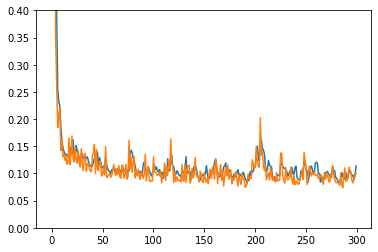

In [ ]:
#plot result
plt.plot(macro_ecb_history.history['root_mean_squared_error'])
plt.plot(macro_ecb_history.history['val_root_mean_squared_error'])
plt.ylim(0,.4)

In [ ]:
#evaluate on test data
macro_ecb_eval=ecb_hypermodel.evaluate(X_test_ecb, y_test_ecb)

2/2 [==============================] - 0s 5ms/step - loss: 0.0123 - root_mean_squared_error: 0.1109


In [ ]:
#The following code saves the model structure, history, and test results
#to a the colab working directory.

model_structure = ecb_hypermodel.to_json()

model_storage = [model_structure,macro_ecb_history.history['root_mean_squared_error'],
                 macro_ecb_history.history['val_root_mean_squared_error'],
                 macro_ecb_history.params, macro_ecb_eval]

#Write to local colab drive

with open("/content/baseline_ecb_model_tuned", "w") as fp:
  json.dump(model_storage, fp)

## Tune US Model

### **Must disconnect and delete run time to run additional Keras Tuner Model.**

In [ ]:
tuner2 = keras_tuner.RandomSearch(tune,
                     objective='val_loss',
                     max_trials=50,
                     seed=42)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

tuner2.search(X_train_us, y_train_us, epochs=300, validation_data=(X_val_us, y_val_us))

In [ ]:
tuner2.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
activation: tanh
units1: 288
units2: 48
dropout: False
learning_rate: 0.01
Score: 0.028035221621394157
Trial summary
Hyperparameters:
activation: tanh
units1: 464
units2: 240
dropout: False
learning_rate: 0.01
Score: 0.028588950634002686
Trial summary
Hyperparameters:
activation: tanh
units1: 384
units2: 320
dropout: False
learning_rate: 0.01
Score: 0.029413394629955292
Trial summary
Hyperparameters:
activation: relu
units1: 368
units2: 480
dropout: True
learning_rate: 0.01
Score: 0.029434697702527046
Trial summary
Hyperparameters:
activation: relu
units1: 48
units2: 496
dropout: True
learning_rate: 0.01
Score: 0.03057444840669632
Trial summary
Hyperparameters:
activation: relu
units1: 48
units2: 192
dropout: True
learning_rate: 0.01
Score: 0.03093603439629078
Trial summary
Hyperparameters:
activation: relu
units1: 480
units2: 464
dropout: True
learning_rate: 0.01
Score: 0.03107583895325

In [ ]:
us_best_hps_tuned=tuner2.get_best_hyperparameters()[0]
us_hypermodel = tuner2.hypermodel.build(us_best_hps_tuned)
us_hypermodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 288)               1152      
                                                                 
 dense_4 (Dense)             (None, 48)                13872     
                                                                 
 dense_5 (Dense)             (None, 1)                 49        
                                                                 
Total params: 15,073
Trainable params: 15,073
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the tuned model
macro_us_history=us_hypermodel.fit(X_train_us, y_train_us, epochs=2500,
                       validation_data=(X_val_us, y_val_us), verbose=False)

<Figure size 432x288 with 0 Axes>

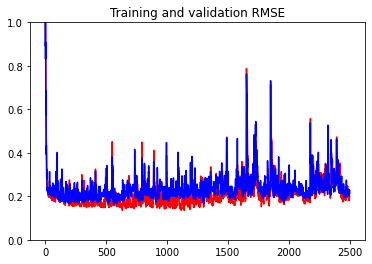

<Figure size 432x288 with 0 Axes>

In [ ]:
#plot result
rmse = macro_us_history.history['root_mean_squared_error']
val_rmse = macro_us_history.history['val_root_mean_squared_error']
epochs=range(len(rmse))
plt.plot(epochs, rmse, 'r')
plt.plot(epochs, val_rmse, 'b')
plt.title('Training and validation RMSE')
plt.ylim((0,1))
plt.figure()

In [ ]:
macro_us_eval=us_hypermodel.evaluate(X_test_us, y_test_us)

2/2 [==============================] - 0s 5ms/step - loss: 0.0713 - root_mean_squared_error: 0.2670


In [ ]:

model_structure = us_hypermodel.to_json()

model_storage = [model_structure,macro_us_history.history['root_mean_squared_error'],
                 macro_us_history.history['val_root_mean_squared_error'],
                 macro_us_history.params, macro_us_eval]

#Write to local colab drive

with open("/content/baseline_us_from_tuner3", "w") as fp:
  json.dump(model_storage, fp)


## Final US Model

For the US model, we found that the best results in practice was informed by the top 10 tuner results, but not identical.  Outperforming the best performing tuned model was one with 2 dense layers with 480 and 460 nodes; no drop out layer and a slower learning rate (.001 vs. .01).

In [ ]:
tf.keras.backend.clear_session()
baseline_us = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3)),  #3 variables
    tf.keras.layers.Dense(480, activation='relu'),
    tf.keras.layers.Dense(464, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
#Compile
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
baseline_us.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
baseline_us.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 480)               1920      
                                                                 
 dense_1 (Dense)             (None, 464)               223184    
                                                                 
 dense_2 (Dense)             (None, 1)                 465       
                                                                 
Total params: 225,569
Trainable params: 225,569
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 2500
early_stop = EarlyStopping(monitor='val_root_mean_squared_error',
                           mode='min', patience=50, verbose=True)
history = baseline_us.fit(X_train_us, y_train_us,
                    epochs=num_epochs,
                    verbose=False,
                    callbacks=[early_stop],
                    validation_data=(X_val_us, y_val_us))

Epoch 146: early stopping


<Figure size 432x288 with 0 Axes>

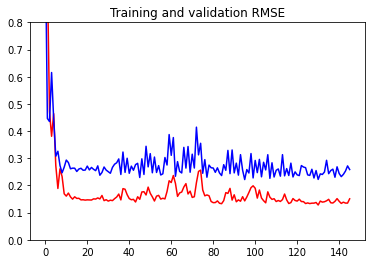

<Figure size 432x288 with 0 Axes>

In [ ]:
#@title
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']
epochs=range(len(rmse))
plt.plot(epochs, rmse, 'r')
plt.plot(epochs, val_rmse, 'b')
plt.title('Training and validation RMSE')
plt.ylim((0,.8))
plt.figure()

In [ ]:
#Evaluate on test data
baseline_us_eval=baseline_us.evaluate(X_test_us, y_test_us)
baseline_us_eval #2500 epochs

2/2 [==============================] - 0s 6ms/step - loss: 0.0379 - root_mean_squared_error: 0.1948


[0.03794848546385765, 0.19480371475219727]

In [ ]:
model_structure = baseline_us.to_json()

model_storage1 = [model_structure,history.history['root_mean_squared_error'],
                 history.history['val_root_mean_squared_error'],
                 history.params, baseline_us_eval]

#Write to local colab drive

with open("/content/baseline_us", "w") as fp:
  json.dump(model_storage1, fp)

## US Model with faster learning rate (.01)

In [ ]:
#Compile
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
baseline_us.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
num_epochs = 2500
#early_stop = EarlyStopping(monitor='val_root_mean_squared_error',
                           #mode='min', patience=50, verbose=False)
history_fast = baseline_us.fit(X_train_us, y_train_us,
                    epochs=num_epochs, verbose=False,
                    #callbacks=[early_stop],
                    validation_data=(X_val_us, y_val_us))

<Figure size 432x288 with 0 Axes>

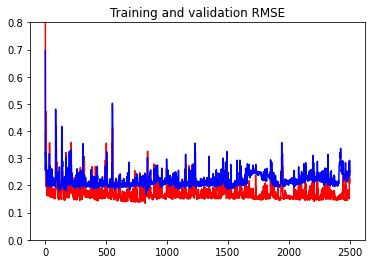

<Figure size 432x288 with 0 Axes>

In [ ]:
#@title
rmse = history_fast.history['root_mean_squared_error']
val_rmse = history_fast.history['val_root_mean_squared_error']
epochs=range(len(rmse))
plt.plot(epochs, rmse, 'r')
plt.plot(epochs, val_rmse, 'b')
plt.title('Training and validation RMSE')
plt.ylim((0,.8))
plt.figure()

In [ ]:
#Evaluate on test data
baseline_us_eval=baseline_us.evaluate(X_test_us, y_test_us)
baseline_us_eval #2500 epochs

2/2 [==============================] - 0s 5ms/step - loss: 0.1030 - root_mean_squared_error: 0.3210


[0.10303634405136108, 0.32099273800849915]

In [ ]:
model_structure = baseline_us.to_json()

model_storage1 = [model_structure,history_fast.history['root_mean_squared_error'],
                 history_fast.history['val_root_mean_squared_error'],
                 history_fast.params, baseline_us_eval]

#Write to local colab drive

with open("/content/baseline_us_fast", "w") as fp:
  json.dump(model_storage1, fp)

# **Models with text**

In this model, our own corpus is the source of the embedding layer.  By using our own embeddings we may be making training less efficient and generalizable than if we used a pre-trained model.  Given the small size of our data set, however, training is still very fast and because of the highly specialized nature of our corpus, self-created embeddings could be more predictive.  

The next section of code was demonstrated by Sucky in:
https://towardsdatascience.com/a-complete-step-by-step-tutorial-on-sentiment-analysis-in-keras-and-tensorflow-ea420cc8913f. It offers a straightforward way to create embeddings in Keras and incorporate them into a neural network.

The first step is to ensure that the data are in the correct format:  the statement should be a string and the target variables, y_std_curr and y_std should be floats.

In [ ]:
df_test_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   level_0                 34 non-null     int64  
 1   index                   34 non-null     int64  
 2   bank                    34 non-null     object 
 3   filename                34 non-null     object 
 4   date_dt                 34 non-null     object 
 5   chron_order_in_country  34 non-null     int64  
 6   rate_curr               34 non-null     float64
 7   rate_next               34 non-null     float64
 8   rate_change             34 non-null     int64  
 9   urate                   34 non-null     float64
 10  inf                     34 non-null     float64
 11  eff_rate                34 non-null     float64
 12  statement               34 non-null     object 
 13  text_include            34 non-null     int64  
 14  nairu                   34 non-null     floa

## Statistics

Knowing the length of each statement will guide our choice of dimensions later.  

The max approximate length of the statements is 475.

In [ ]:
approx_length = df_train_us['statement'].str.split(" ").str.len()
approx_length.describe()

count    101.000000
mean     338.821782
std      171.129623
min      105.000000
25%      179.000000
50%      338.000000
75%      453.000000
max      764.000000
Name: statement, dtype: float64

## Prepare data for embeddings
 As a reminder the y values are defined in the function make_matrixes and are called:

* y_train_us, y_val_us, y_test_us

Also, note that rate_change should be in the necessary form if we ran the function rate_change_var above.  

In [ ]:
def prep_text(texttrain, textval, texttest):
  tr_sentences=np.array(texttrain)
  val_sentences=np.array(textval)
  test_sentences=np.array(texttest)
  return tr_sentences, val_sentences, test_sentences

In [ ]:
#Convert text statements to numpy arrays - US
training_sentences_us, val_sentences_us, testing_sentences_us = prep_text(df_train_us.statement,\
                                                                          df_val_us.statement,\
                                                                          df_test_us.statement)

In [ ]:
#Convert rename
# Continuous target variable
training_labels_final_us, val_labels_final_us, test_labels_final_us = prep_text(y_train_us, y_val_us, y_test_us)

print(training_labels_final_us.shape, val_labels_final_us.shape, test_labels_final_us.shape)

(101,) (34,) (34,)


In [ ]:
# Classification (up or not) - this code is just to match naming conventions below.
clf_train_us = np.array(df_train_us.rate_change)
clf_test_us = np.array(df_test_us.rate_change)
clf_val_us = np.array(df_val_us.rate_change)
print(clf_train_us.shape, clf_val_us.shape, clf_test_us.shape)

(101,) (34,) (34,)


In [ ]:
#Convert rename
# Continuous target variable
training_labels_final_ecb, val_labels_final_ecb, test_labels_final_ecb = prep_text(y_train_ecb, y_val_ecb, y_test_ecb)

print(training_labels_final_ecb.shape, val_labels_final_ecb.shape, test_labels_final_ecb.shape)

(159,) (53,) (53,)


# Embedding based on the corpus

We first examine embeddings based on the corpus.  

* The embedding will look at the first 800 words in each statement. Since the maximum length in our dataset is only about 765 words, this is not binding.  However, we choose a larger value to accomodate potentially longer statements in the future.

* There is no need to truncate statements in the current file, but to accomodate future data we set the tokenizer to truncate words at the end of each statement.

* To ensure the embeddings are all the same length, statements padded with zeros to make them all 800 in length.

* We choose a vocab_size for the corpus

* The 'OOV' token represents words that occur with low frequency and are not part of the vocabulary.

* An embedding dimension of 16 means that the embedding will be a matrix of 1300 (number of tokens) by 16 (size of the vector for each token).  These vectors can be thought of as the 'features' for each token, and help the model understand the similarity between tokens and statements.

In [ ]:
max_length = 800 #Number of tokens per statement
trunc_type = 'post'
padding_type = 'post'

vocab_size = 1300 #changed this based on word_index below
oov_tok = '<OOV>' #indicate out of vocabularly words

embedding_dim = 16 #number of features per word in vocabulary

### From here, I am dealing only with US text data.

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences_us)
word_index = tokenizer.word_index

In [ ]:
#Find the indexes for select words from the word index
check_list=['inflation',
            'debt','current','projections','expansion','mortgage',
            'near', 'vaccinations',
            'short','stability','price','unemployment','hurricane',
            'covid','weather',
            'basis','asset']

[word_index[i] for i in check_list]

[7,
 164,
 205,
 1166,
 303,
 53,
 115,
 454,
 821,
 41,
 40,
 95,
 662,
 561,
 883,
 120,
 125]

In [ ]:
len(word_index)

1258

In [ ]:
#Get a count of select words
[tokenizer.word_counts[i] for i in check_list[1:]]

[38, 31, 1, 17, 122, 55, 9, 2, 143, 147, 72, 4, 6, 2, 54, 51]

Assure that the arrays fed into the neural network are all the same length.  We "pad" the sequences that are less than the maximum length so they are all the same size.

In [ ]:
#For the US ONLY
sequences_us = tokenizer.texts_to_sequences(training_sentences_us)
padded_us = pad_sequences(sequences_us, maxlen=max_length, truncating=trunc_type)

val_sequences_us = tokenizer.texts_to_sequences(val_sentences_us)
val_padded_us = pad_sequences(val_sequences_us, maxlen=max_length)

test_sequences_us = tokenizer.texts_to_sequences(testing_sentences_us)
test_padded_us = pad_sequences(test_sequences_us, maxlen=max_length)

Let's take a look at these sequences arrays.

In [ ]:
print(padded_us.shape, val_padded_us.shape, test_padded_us.shape)

(101, 800) (34, 800) (34, 800)


In [ ]:
padded_us

array([[  0,   0,   0, ...,   3, 183,  57],
       [  0,   0,   0, ..., 101, 107, 203],
       [  0,   0,   0, ...,  15,   4,   4],
       ...,
       [  0,   0,   0, ...,  18,  25,  15],
       [  0,   0,   0, ...,  52, 111, 252],
       [  0,   0,   0, ..., 740,  27, 563]], dtype=int32)

## A simple LSTM on the text data only: RMSE 0.50

For the sake of consistency and after some experimentation, we decided to use the same dense layers as in macro model.

In [ ]:
#LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(embedding_dim),
    tf.keras.layers.Dense(480, activation='relu'), #16 had RMSE of .62
    tf.keras.layers.Dense(464, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
model_lstm.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
num_epochs = 2500
early_stop = EarlyStopping(monitor='val_root_mean_squared_error', mode='min', patience=200, verbose=False)
history = model_lstm.fit(padded_us, y_train_us,
                    epochs=num_epochs, verbose=False, callbacks=[early_stop],
                    validation_data=(val_padded_us, y_val_us))

<Figure size 432x288 with 0 Axes>

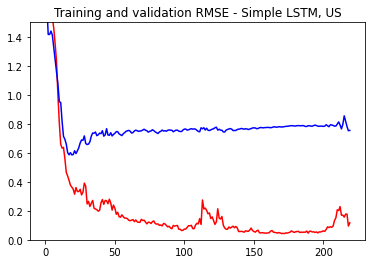

<Figure size 432x288 with 0 Axes>

In [ ]:
#@title
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']
epochs=range(len(rmse))
plt.plot(epochs, rmse, 'r')
plt.plot(epochs, val_rmse, 'b')
plt.title('Training and validation RMSE - Simple LSTM, US')
plt.ylim((0,1.5))
plt.figure()

In [ ]:
model_lstm_eval=model_lstm.evaluate(test_padded_us, y_test_us)
model_lstm_eval

2/2 [==============================] - 0s 18ms/step - loss: 0.3411 - root_mean_squared_error: 0.5840


[0.3410837948322296, 0.5840237736701965]

## Model with both text and macro variables, embeddings from our corpus, US data.  RMSE: 0.196.

In [ ]:
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Input
from keras.models import Model

def make_model_no_matrix(max_length,embedding_dim):

    # Defining the embedding layer
    input1=Input(shape=(max_length,)) # max_length is the length of each input sequence

    embedding_layer = Embedding(vocab_size, embedding_dim,   #len(word_index)+1,100
                                input_length=max_length,trainable=True
                                )(input1)


    # Building LSTM for text features

    bi_lstm_1 = Bidirectional(LSTM(embedding_dim,return_sequences=True))(embedding_layer) # original first layer -
    # the return_sequences=True gives it an extra dimension that then has to be fixed with the second lstm before concatenation

    bi_lstm_2 = Bidirectional(LSTM(embedding_dim))(bi_lstm_1)  #original second LSTM
    lstm_output =  Model(inputs = input1,outputs = bi_lstm_2) # original output of layered LSTM's

#Inputting Number features
    input2=Input(shape=(3,))

    # Merging inputs
    merge = tf.keras.layers.concatenate([lstm_output.output,input2])

    # Building dense layers for regression with number features
    reg_dense1 = Dense(480, activation='relu')(merge)
    reg_dense2 = Dense(464, activation='relu')(reg_dense1)
    output1 = Dense(1, activation='linear')(reg_dense2)


    model = Model(inputs=[lstm_output.input,input2], outputs=[output1])  #outputs=[output1,output2]

    return model

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
import keras
from keras.optimizers import Adam

model = make_model_no_matrix(max_length,16)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 800)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 800, 16)      20800       ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 800, 32)      4224        ['embedding[0][0]']              
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 32)          6272        ['bidirectional[0][0]']          
 )                                                                                          

In [ ]:
regression_losses ={ 'dense_2':"mse"}
regression_metrics = {'dense_2': tf.keras.metrics.RootMeanSquaredError()}
opt = Adam(learning_rate=0.001)

In [ ]:
# Model Compiling
model.compile(optimizer=opt, loss=regression_losses,metrics=regression_metrics) # original was model.compile(optimizer=opt, loss="mse",metrics=metrics)

In [ ]:
# Model Fitting
num_epochs = 2500
early_stop = EarlyStopping(monitor='val_root_mean_squared_error', mode='min', patience=200, verbose=False)
H = model.fit(x=[padded_us, X_train_us], # text training input first, then numerical training in put
y={'dense_2': training_labels_final_us},
validation_data=([val_padded_us, X_val_us],{'dense_2': val_labels_final_us}),
epochs=num_epochs,verbose=1, callbacks=[early_stop])


In [ ]:
model.evaluate({'input_1': test_padded_us,'input_2': X_test_us}, {'dense_2': y_test_us})


2/2 [==============================] - 1s 58ms/step - loss: 0.0484 - root_mean_squared_error: 0.2199


[0.04836930334568024, 0.21993021667003632]

In [ ]:
rmse = H.H['root_mean_squared_error']
val_rmse = H.H['val_root_mean_squared_error']
epochs=range(len(rmse))
plt.plot(epochs, rmse, 'r')
plt.plot(epochs, val_rmse, 'b')
plt.title('Training and validation RMSE - Embeddings from Corpus')
plt.ylim((0,1.5))
plt.figure()

### Again for the sake of comparison, we use a single LSTM on the text and macrovariables.

In [ ]:
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Input
from keras.models import Model

def make_model_no_matrix_single_lstm(max_length,embedding_dim):

    # Defining the embedding layer
    input1=Input(shape=(max_length,)) # max_length is the length of each input sequence

    embedding_layer = Embedding(vocab_size, embedding_dim,   #len(word_index)+1,100
                                input_length=max_length,trainable=True
                                )(input1)


    # Building LSTM for text features

    lstm_1 = LSTM(embedding_dim)(embedding_layer) # original first layer -
    # the return_sequences=True gives it an extra dimension that then has to be fixed with the second lstm before concatenation

    #bi_lstm_2 = Bidirectional(LSTM(embedding_dim))(bi_lstm_1)  #original second LSTM
    lstm_output =  Model(inputs = input1,outputs = lstm_1) # original output of layered LSTM's

#Inputting Number features
    input2=Input(shape=(3,))

    # Merging inputs
    merge = tf.keras.layers.concatenate([lstm_output.output,input2])

    # Building dense layers for regression with number features
    reg_dense1 = Dense(480, activation='relu')(merge)
    reg_dense2 = Dense(464, activation='relu')(reg_dense1)
    output1 = Dense(1, activation='linear')(reg_dense2)


    model = Model(inputs=[lstm_output.input,input2], outputs=[output1])  #outputs=[output1,output2]

    return model

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
import keras
from keras.optimizers import Adam

model_single_lstm = make_model_no_matrix_single_lstm(max_length,16)

In [ ]:
model_single_lstm.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 800)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 800, 16)      20800       ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 16)           2112        ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 3)]          0           []                               
                                                                                            

In [ ]:
regression_losses ={ 'dense_2':"mse"}
regression_metrics = {'dense_2': tf.keras.metrics.RootMeanSquaredError()}
opt = Adam(learning_rate=0.001)

In [ ]:
# Model Compiling
model_single_lstm.compile(optimizer=opt, loss=regression_losses,metrics=regression_metrics) # original was model.compile(optimizer=opt, loss="mse",metrics=metrics)

In [ ]:
# Model Fitting
num_epochs = 2500
early_stop = EarlyStopping(monitor='val_root_mean_squared_error', mode='min', patience=200, verbose=False)
H = model_single_lstm.fit(x=[padded_us, X_train_us], # text training input first, then numerical training in put
y={'dense_2': training_labels_final_us},
validation_data=([val_padded_us, X_val_us],{'dense_2': val_labels_final_us}),
epochs=num_epochs,verbose=0, callbacks=[early_stop])


In [ ]:
model_single_lstm.evaluate({'input_1': test_padded_us,'input_2': X_test_us}, {'dense_2': y_test_us})


2/2 [==============================] - 1s 17ms/step - loss: 0.0677 - root_mean_squared_error: 0.2601


[0.0676666796207428, 0.2601282000541687]

## Testing on ECB data.  

Although the ECB text data was too limited to use for training purposes, we use it to test the model created from our US data.  As seen, the RMSE is very close at 0.2268.  

In [ ]:
#Restrict the dataframe to ECB entries with rows that have text sturdy enough to use.
df_ecb_text = df.loc[(df['bank']=='ecb') & (df['text_include']==1)] #get the relevant entries

In [ ]:
#Convert text statements to numpy arrays - ECB
testing_sentences_ecb = np.array(df_ecb_text.statement)

In [ ]:
test_sequences_ecb = tokenizer.texts_to_sequences(testing_sentences_ecb)
test_padded_ecb = pad_sequences(test_sequences_ecb, maxlen=max_length)

In [ ]:
test_padded_ecb.shape

(46, 800)

In [ ]:
#Pull the macro data from the same rows of the matrix.
X_test_ecb_restricted, y_test_ecb_restricted = make_matrixes(df_ecb_text, "no aug", scaled=0)

(46, 3) (46,)


In [ ]:
model.evaluate({'input_1': test_padded_ecb,'input_2': X_test_ecb_restricted}, {'dense_2': y_test_ecb_restricted})

2/2 [==============================] - 0s 63ms/step - loss: 0.0514 - root_mean_squared_error: 0.2268


[0.051429104059934616, 0.22677986323833466]

### Variation: a single bidirectional LSTM with text and macro variables, US data.  

Note that we have to drop the "return_sequences=True" to do this.  It gives me an RMSE of 0.231.

In [ ]:
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Input
from keras.models import Model

def make_model_single_bi_lstm(max_length,embedding_dim):

    # Defining the embedding layer
    input1=Input(shape=(max_length,)) # max_length is the length of each input sequence

    embedding_layer = Embedding(vocab_size, embedding_dim,
                                input_length=max_length,trainable=True
                                )(input1)


    # Building LSTM for text features

    bi_lstm_1 = Bidirectional(LSTM(embedding_dim))(embedding_layer) # original first layer -
    # the return_sequences=True gives it an extra dimension that then has to be fixed with the second lstm before concatenation

    #bi_lstm_2 = Bidirectional(LSTM(embedding_dim))(bi_lstm_1)  #original second LSTM
    lstm_output =  Model(inputs = input1,outputs = bi_lstm_1)

#Inputting Number features
    input2=Input(shape=(3,))

    # Merging inputs
    merge = tf.keras.layers.concatenate([lstm_output.output,input2])

    # Building dense layers for regression with number features
    reg_dense1 = Dense(480, activation='relu')(merge)
    reg_dense2 = Dense(464, activation='relu')(reg_dense1)
    output1 = Dense(1, activation='linear')(reg_dense2)


    model = Model(inputs=[lstm_output.input,input2], outputs=[output1])

    return model

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
import keras
from keras.optimizers import Adam

model = make_model_single_bi_lstm(max_length,16)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 800)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 800, 16)      20800       ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 32)           4224        ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 3)]          0           []                               
                                                                                            

In [ ]:
# Model Compiling
model.compile(optimizer=opt, loss=regression_losses,metrics=regression_metrics) # original was model.compile(optimizer=opt, loss="mse",metrics=metrics)

In [ ]:
# Model Fitting
H = model.fit(x=[padded_us, X_train_us], # text training input first, then numerical training in put
y={'dense_2': training_labels_final_us},
validation_data=([val_padded_us, X_val_us],{'dense_2': val_labels_final_us}),
epochs=2500,verbose=0, callbacks=[early_stop])



In [ ]:
model.evaluate({'input_1': test_padded_us,'input_2': X_test_us}, {'dense_2': y_test_us})


2/2 [==============================] - 1s 26ms/step - loss: 0.0534 - root_mean_squared_error: 0.2310


[0.05337190255522728, 0.23102359473705292]

## Classification Model (Predicting Next Rate up or not) with both text and macrovariable input.   **Precision =1.000**!

We chose not to use early stopping here because we got excellent results with a standard choice of 200 epochs.

In [ ]:
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Input
from keras.models import Model

def classification_model_no_matrix(max_length,embedding_dim):

    # Defining the embedding layer
    input1=Input(shape=(max_length,))

    embedding_layer = Embedding(vocab_size, embedding_dim,
                                input_length=max_length,trainable=True
                                )(input1)


    # Building LSTM for text features
    bi_lstm_1 = Bidirectional(LSTM(embedding_dim,return_sequences=True))(embedding_layer)

    bi_lstm_2 = Bidirectional(LSTM(embedding_dim))(bi_lstm_1)
    lstm_output =  Model(inputs = input1,outputs = bi_lstm_2)

    #Inputting Number features
    input2=Input(shape=(3,))

    # Merging inputs
    merge = tf.keras.layers.concatenate([lstm_output.output,input2])

    # Building dense layers for classification with number features
    clf_dense1 = Dense(4, activation='relu')(merge)
    clf_dense2 = Dense(4, activation='relu')(clf_dense1)

    # 2 Categories in classification
    output2 = Dense(1, activation='sigmoid')(clf_dense1)

    model = Model(inputs=[lstm_output.input,input2], outputs=[output2])

    return model

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model_basic_class = classification_model_no_matrix(max_length,16)

In [ ]:
model_basic_class.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 800)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 800, 16)      20800       ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 800, 32)      4224        ['embedding[0][0]']              
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 32)          6272        ['bidirectional[0][0]']          
 )                                                                                          

In [ ]:
class_losses ={'dense_2':tf.keras.losses.BinaryCrossentropy()}
class_metrics = {'dense_2': tf.keras.metrics.Precision()}

opt = Adam(learning_rate=0.001)

In [ ]:
# Model Compiling
model_basic_class.compile(optimizer=opt, loss=class_losses,metrics=class_metrics)

In [ ]:
# Model Fitting
#early_stop_clf = EarlyStopping(monitor='val_precision', mode='max', patience=300, verbose=False)
H = model_basic_class.fit(x=[padded_us, X_train_us], # text training input first, then numerical training in put
y={'dense_2': clf_train_us}, # two sets of labels, one for the next rate and one for the classification
validation_data=([val_padded_us, X_val_us],{'dense_2': clf_val_us}), # validation for text, validation for numerical
epochs=200,verbose=0)



In [ ]:
model_basic_class.evaluate({'input_1': test_padded_us,'input_2': X_test_us}, {'dense_2': clf_test_us})

2/2 [==============================] - 1s 61ms/step - loss: 0.4422 - precision: 1.0000


[0.4422171115875244, 1.0]

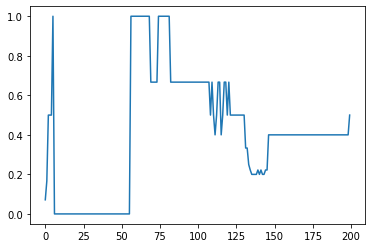

In [ ]:
plt.plot(H.history['val_precision'])

# **Pre-trained embedding specialized for Central Banks**


First we apply the central bank-specific embeddings by Zahner and Baumgaertner predicting the next rate.  We will first explore the embeddings then run the models.  We find there are over 72,000 word vectors and 300 features per word.  

In [ ]:
zb = pd.read_csv('word_embeddings_3b.csv')

In [ ]:
zb.shape

(73082, 301)

In [ ]:
zb=zb.set_index('word')


In [ ]:
zb_transposed = zb.T

In [ ]:
list_of_columns = zb.values.tolist()

In [ ]:
words=list(zb_transposed.columns.values)

In [ ]:
embeddings_index = {} # key: word, value: vector

for i in range(len(words)):
    embeddings_index[words[i]]=list_of_columns[i]


print("Found %s word vectors." % len(embeddings_index))

Found 72096 word vectors.


### Prepare pretrained embeddings see how many words in our vocabulary are in the pre-trained model

Source:  https://keras.io/examples/nlp/pretrained_word_embeddings/

In [ ]:

num_tokens = len(range(vocab_size)) + 2
embedding_dim = 300 #number of features per word in pre-trained model
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        #print(word, end ="")
        print(word)
#print("Converted %d words (%d misses)" % (hits, misses))


<OOV>
actionsthe
banksinformation


In [ ]:
print(embedding_matrix.shape)

(1302, 300)


## Define and test model

This inputs the text through our embedding matrix and the numerical features.  It predicts the next rate (RMSE).  

We tried numerous variants of an LSTM model including 2 bidirectional LSTMs (below), a single uni-directional LSTM, and 2 unidirectional-LSTM layers. All had similar performance.

The following resource was very helpful.  https://blog.paperspace.com/combining-multiple-features-outputs-keras/

## US data, text and macros, ZB embeddings: RMSE 0.198

In [ ]:
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Input
from keras.models import Model

def make_model(max_length,embedding_matrix,embedding_dim):

    # Defining the embedding layer
    input1=Input(shape=(max_length,))

    embedding_layer = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],  #len(word_index)+1,100
                                weights=[embedding_matrix],
                                input_length=max_length,
                                trainable=False)(input1)

    # Building LSTM for text features
    bi_lstm_1 = Bidirectional(LSTM(embedding_dim,return_sequences=True))(embedding_layer)

    bi_lstm_2 = Bidirectional(LSTM(embedding_dim))(bi_lstm_1)
    lstm_output =  Model(inputs = input1,outputs = bi_lstm_2)

    #Inputting Number features
    input2=Input(shape=(3,))

    # Merging inputs
    merge = tf.keras.layers.concatenate([lstm_output.output,input2])

    # Building dense layers for regression with number features
    reg_dense1 = Dense(480, activation='relu')(merge)
    reg_dense2 = Dense(464, activation='relu')(reg_dense1)
    output1 = Dense(1, activation='linear')(reg_dense2)

    model = Model(inputs=[lstm_output.input,input2], outputs=[output1])

    return model

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = make_model(max_length,embedding_matrix,300)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 800)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 800, 300)     390600      ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 800, 600)     1442400     ['embedding[0][0]']              
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 600)         2162400     ['bidirectional[0][0]']          
 )                                                                                          

In [ ]:
# Model Compiling
model.compile(optimizer=opt, loss=regression_losses,metrics=regression_metrics) #model.compile(optimizer=opt, loss="mse",metrics=metrics)

In [ ]:
# Model Fitting
H = model.fit(x=[padded_us, X_train_us], # text training input first, then numerical training in put
y={'dense_2': training_labels_final_us}, # two sets of labels, one for the next rate and one for the classification
validation_data=([val_padded_us, X_val_us],{'dense_2': val_labels_final_us}), # validation for text, validation for numerical
epochs=2500,verbose=0, callbacks=[early_stop])



In [ ]:
model.evaluate({'input_1': test_padded_us,'input_2': X_test_us}, {'dense_2': y_test_us})

2/2 [==============================] - 1s 56ms/step - loss: 0.0393 - root_mean_squared_error: 0.1983


[0.03933556005358696, 0.19833193719387054]

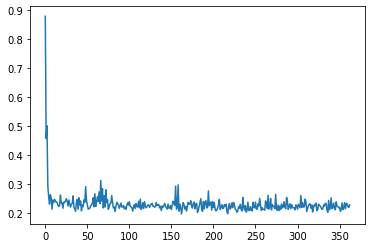

In [ ]:
plt.plot(H.history['val_root_mean_squared_error'])

# **GloVe Embeddings**

After downloading GloVe, we adapt our code to use it.  GloVe contains 400,000 tokens and comes with a variety of embedding dims.  We chose the smallest - 50 features per token.

All but 45 words in our vocab were in GloVE.  The "misses" tended to be words with apostrophes, abbreviations and compound words **(later we will clean our data to better match the pre-trained embeddings).**

In [ ]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip

In [ ]:
embeddings_index_glove = {}
with open('glove.6B.50d.txt', encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index_glove[word] = coefs

print("Found %s word vectors." % len(embeddings_index_glove))

Found 400000 word vectors.


In [ ]:
num_tokens = len(range(vocab_size)) + 2 #vocab size was specified in Part I
embedding_dim = 50 #we chose the 50-dim embedding of GloVE
hits = 0
misses = 0

# Prepare embedding matrix. This matrix matches OUR vocabulary to the ELEMENTS in GloVE.
embedding_matrix_glove = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index_glove.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix_glove[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        #print(word, end ="")
        print(word)
print("Converted %d words (%d misses)" % (hits, misses))

<OOV>
covid
actionsthe
banksinformation
Converted 1254 words (4 misses)


In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

### US data, text and macros, GloVe embedding matrix: RMSE 0.2241



In [ ]:
import keras
from keras.optimizers import Adam

model_glove = make_model(max_length,embedding_matrix_glove,50)

In [ ]:
model_glove.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 800)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 800, 50)      65100       ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 800, 100)     40400       ['embedding[0][0]']              
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 100)         60400       ['bidirectional[0][0]']          
 )                                                                                          

In [ ]:
# Model Compiling
model_glove.compile(optimizer=opt, loss=regression_losses,metrics=regression_metrics)

In [ ]:
# Model Fitting

early_stop = EarlyStopping(monitor='val_root_mean_squared_error',
                           mode='min', patience=50, verbose=False)
H = model_glove.fit(x=[padded_us, X_train_us], # text training input first, then numerical training in put
y={'dense_2': training_labels_final_us}, # two sets of labels, one for the next rate and one for the classification
validation_data=([val_padded_us, X_val_us],{'dense_2': val_labels_final_us}), # validation for text, validation for numerical
verbose=0,
epochs=2500,
callbacks=[early_stop])



In [ ]:
model_glove.evaluate({'input_1': test_padded_us,'input_2': X_test_us}, {'dense_2': y_test_us})

2/2 [==============================] - 1s 93ms/step - loss: 0.0502 - root_mean_squared_error: 0.2241


[0.05019845440983772, 0.2240501195192337]

In [ ]:
#df_train_us.to_excel('/content/df_train_us_1204.xlsx')
#df_val_us.to_excel('/content/df_val_us_1204.xlsx')
#df_test_us.to_excel('/content/df_val_us_1204.xlsx')